In [1]:
import matplotlib.pyplot as plt
import numpy as np
# ^^^ pyforest auto-imports - don't write above this line
# from pulp import *
from scipy import interpolate
from scipy.optimize import fmin, fminbound, minimize, BFGS, fmin_bfgs, differential_evolution
import math

In [2]:
class Vehicle:
    def __init__(self, ):
        self.pos=[] # x, y [m]
        self.size=[] # length, width [m]
        self.ori=[] # [rad]
        self.vel=[] # [m/s]

In [3]:
def vehicle_plot(pos, size, ori):
    if 0:
        points = [
            [pos[0] - size[0]/2, pos[0] + size[0]/2, pos[0] + size[0]/2, pos[0] - size[0]/2, pos[0] - size[0]/2],
            [pos[1] - size[1]/2, pos[1] - size[1]/2, pos[1] + size[1]/2, pos[1] + size[1]/2, pos[1] - size[1]/2]
        ]
    else:
        points = [[],[]]
        x = [- size[0]/2, size[0]/2, size[0]/2, - size[0]/2, - size[0]/2]
        y = [- size[1]/2, - size[1]/2, size[1]/2, size[1]/2, - size[1]/2]
        A = [[np.cos(ori), -np.sin(ori)],[np.sin(ori), np.cos(ori)]]
        for i in range(len(x)):
            buf = np.dot(A,np.array([x[i],y[i]]))
            points[0].append(buf[0] + pos[0])
            points[1].append(buf[1] + pos[1])
    plt.plot(points[0], points[1])

In [4]:
road_length = 60

# 駐車車両
parked_vehicle = Vehicle()
parked_vehicle.pos = [road_length/2, 1.5]
parked_vehicle.pos = [road_length/2, .5]
parked_vehicle.size = [4, 2]
parked_vehicle.ori = 0
parked_vehicle.ori = 0

# 自車
ego_vehicle = Vehicle()
ego_vehicle.pos = [0,0]
ego_vehicle.size = [4,2]
ego_vehicle.ori = 0
ego_vehicle.vel = 10/3.6

 # 車線
width_lane = 4
line_left = [[0,road_length],[width_lane/2, width_lane/2]]
line_center = [[0,road_length], [0,0]]
line_right = [[0,road_length],[-width_lane/2, -width_lane/2]]

Text(0, 0.5, 'Y[m]')

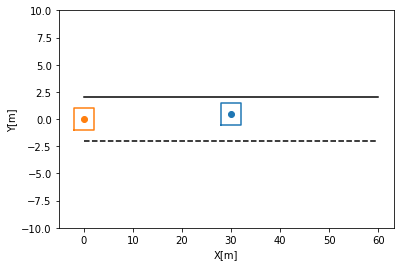

In [5]:
# 描画
plt.scatter(parked_vehicle.pos[0], parked_vehicle.pos[1])
vehicle_plot(parked_vehicle.pos, parked_vehicle.size, parked_vehicle.ori)
plt.scatter(ego_vehicle.pos[0], ego_vehicle.pos[1])
vehicle_plot(ego_vehicle.pos, ego_vehicle.size, ego_vehicle.ori)

plt.plot(line_left[0], line_left[1], 'k')
plt.plot(line_right[0], line_right[1], '--k')

plt.ylim([-10,10])
plt.xlabel('X[m]')
plt.ylabel('Y[m]')

### Ref: https://qiita.com/Ken227/items/aee6c82ec6bab92e6abf

In [6]:
#interpld
# ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0
# 2点だとエラー
def spline1(x,y,point):
    kind_option = 'cubic' if len(x) > 3 else 'quadratic'
    f = interpolate.interp1d(x, y,kind=kind_option) #kindの値は一次ならslinear、二次ならquadraticといった感じに
    X = np.linspace(x[0],x[-1],num=point,endpoint=True)
    Y = f(X)
    return X,Y

#Akima1DInterpolator
def spline2(x,y,point):
    f = interpolate.Akima1DInterpolator(x, y)
    X = np.linspace(x[0],x[-1],num=point,endpoint=True)
    Y = f(X)
    return X,Y

#splprep
def spline3(x,y,point,deg):
    tck,u = interpolate.splprep([x,y],k=deg,s=0) 
    u = np.linspace(0,1,num=point,endpoint=True) 
    spline = interpolate.splev(u,tck)
    return spline[0],spline[1]

### Ref:https://myenigma.hatenablog.com/entry/2016/10/23/043111

In [7]:
# 点列から曲率計算
def CalcCurvature(x,y,npo=1):
    cv=[]

    ndata=len(x)

    for i in range(ndata):
        lind=i-npo
        hind=i+npo+1

        if lind<0:
            lind=0
        if hind>=ndata:
            hind=ndata
        #  print(lind,hind)

        xs=x[lind:hind]
        ys=y[lind:hind]
        #  print(xs,ys)
        (cxe,cye,re)=CircleFitting(xs,ys)
        #  print(re)

        if len(xs)>=3:
            # sign evalation 
            cind=int((len(xs)-1)/2.0)
            sign = (xs[0] - xs[cind]) * (ys[-1] - ys[cind]) - (ys[0] - ys[cind]) * (xs[-1] - xs[cind])

            # check straight line
            a = np.array([xs[0]-xs[cind],ys[0]-ys[cind]])
            b = np.array([xs[-1]-xs[cind],ys[-1]-ys[cind]])
            theta=math.degrees(math.acos(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))))
            #  print(theta)

            if theta==180.0:
                cv.append(0.0)#straight line
            elif sign>0:
                cv.append(1.0/-re)
            else:
                cv.append(1.0/re)
        else:
            cv.append(0.0)

    #  print(cv)
    return cv

# 円フィッティング
def CircleFitting(x,y):
    sumx  = sum(x)
    sumy  = sum(y)
    sumx2 = sum([ix ** 2 for ix in x])
    sumy2 = sum([iy ** 2 for iy in y])
    sumxy = sum([ix * iy for (ix,iy) in zip(x,y)])

    F = np.array([[sumx2,sumxy,sumx],
                  [sumxy,sumy2,sumy],
                  [sumx,sumy,len(x)]])

    G = np.array([[-sum([ix ** 3 + ix*iy **2 for (ix,iy) in zip(x,y)])],
                  [-sum([ix ** 2 *iy + iy **3 for (ix,iy) in zip(x,y)])],
                  [-sum([ix ** 2 + iy **2 for (ix,iy) in zip(x,y)])]])

    try:
        T=np.linalg.inv(F).dot(G)
    except:
        return (0,0,float("inf"))

    cxe=float(T[0]/-2)
    cye=float(T[1]/-2)
    #  print (cxe,cye,T)
    try:
        re=math.sqrt(cxe**2+cye**2-T[2])
    except:
        return (cxe,cye,float("inf"))
    return (cxe,cye,re)

In [8]:
# 経路評価
def evaluation_path(X):
    # X = [x1, y1, xpre, xback]
    
    points = [
        [ego_vehicle.pos[0], parked_vehicle.pos[0] - X[2], parked_vehicle.pos[0] + X[0], parked_vehicle.pos[0] + X[3], line_center[0][1]], 
        [ego_vehicle.pos[1], ego_vehicle.pos[1], parked_vehicle.pos[1] + X[1], ego_vehicle.pos[1], line_center[1][1]]
    ]
    
    print("points : ", points)
    
    if ((X[0] + X[2]) > 0) & ((-X[0] + X[3]) > 0):
    
        if 0:
            path_coef = np.polyfit(points[0], points[1], 6)
            path_x= np.linspace(ego_vehicle.pos[0], line_left[0][1], 20)
            path_y = np.poly1d(path_coef)(path_x)
        else:
            path_x, path_y = spline2(points[0], points[1], 20)


        eval_val = 0 

        # (１)死角
        w_dead_area = 1
        eval_val += w_dead_area * calculation_dead_area(path_x, path_y, X[2])

        # (２)はみ出し
        w_out_of_road = 1000
        eval_val += w_out_of_road * calculation_out_of_road(path_x, path_y)

        # (３)衝突
        w_collision = 1000
        eval_val += w_collision * calculation_collision(path_x, path_y)

        # (４)道路中央を走行
        w_center_of_road = 1
        eval_val += w_center_of_road * calculation_center_of_road(path_x, path_y)

        # (５)ジャーク（yの二回微分）
        w_lat_jark = 1000000
        eval_val += w_lat_jark * calculation_lat_jark(path_x, path_y)    

        # (６)ハンドル角速度（曲率変化量） 
        w_steer_vel = 100000
        eval_val += w_steer_vel * calculation_steer_vel(path_x, path_y)
    else:
        eval_val = 1e100
        
    return eval_val

# 制約(cons >= 0)
def cons_1(X):
    return (X[0] + X[2])

def cons_2(X):
    return (-X[0] + X[3])

In [9]:
# 死角の計算
def calculation_dead_area(path_x, path_y , pre):
    fr = [parked_vehicle.pos[0] + parked_vehicle.size[0]/2, parked_vehicle.pos[1] - parked_vehicle.size[1]/2]
    fl = [parked_vehicle.pos[0] + parked_vehicle.size[0]/2, parked_vehicle.pos[1] + parked_vehicle.size[1]/2]
    
    dead_area = 0
    pp = [0, 0]
    
    if 0:
        plt.scatter(parked_vehicle.pos[0], parked_vehicle.pos[1])
        vehicle_plot(parked_vehicle.pos, parked_vehicle.size, parked_vehicle.ori)
        plt.scatter(ego_vehicle.pos[0], ego_vehicle.pos[1])
        vehicle_plot(ego_vehicle.pos, ego_vehicle.size, ego_vehicle.ori)

        plt.plot(line_left[0], line_left[1], 'k')
        plt.plot(line_right[0], line_right[1], '--k')

        plt.ylim([-10,10])
        plt.xlim([0,line_center[0][1]])
        plt.xlabel('X[m]')
        plt.ylabel('Y[m]')
    
    for i in range(len(path_x)):
        if 0:
            a = ( (fr[0] - path_x[i]) / (fr[1] - path_y[i]) ) * parked_vehicle.size[1]
            b = parked_vehicle.size[1] 
            dead_area += a * b * 1/2
        else:
            # if (path_x[i] < fr[0]) & (parked_vehicle.pos[0] - pre > path_x[i]):
            if (path_x[i] < fr[0]):
                a = (fr[1] - path_y[i]) / (fr[0] - path_x[i])
                b = fr[1] - a * fr[0]
                
                pp[0] = (fl[1] - b)/a
                pp[1] = fl[1]

                if (pp[0] > fl[0]):
                    dead_area += (pp[0] - fl[0])*(fl[1] - fr[1])*1/2
                # plt.plot([pp[0], fl[0], fr[0], pp[0]], [pp[1], fl[1], fr[1], pp[1]])
                
                if (path_y[i] > fr[1]):
                    dead_area += 1000
    
    return dead_area

In [10]:
# はみ出し
def calculation_out_of_road(path_x, path_y):
    return np.sum(path_y<line_right[1][0]) + 1000*np.sum(path_y>0)

In [11]:
# 衝突
def calculation_collision(path_x, path_y):
    d = np.sqrt((parked_vehicle.pos[0] - path_x) ** 2 + (parked_vehicle.pos[1] - path_y) ** 2)
    d_min = np.min(d)
    torelance = 3
    ret = np.sum(1/np.exp(d))
    if d_min < torelance:
        #ret = np.inf
        ret = 100000000*ret
        
    return ret

In [12]:
# 道路中央
def calculation_center_of_road(path_x, path_y):
    return np.sum(np.exp(np.abs(path_y - line_center[1][0])))

In [13]:
# 横ジャーク
def calculation_lat_jark(path_x, path_y):
    return np.sum(np.abs(np.diff(path_y, n=2)))

In [14]:
# ハンドル角速度
def calculation_steer_vel(path_x, path_y):
    cv = CalcCurvature(path_x, path_y)
    # plt.scatter(path_x, cv)
    return np.sum(np.abs(np.diff(cv, n=1)))

In [15]:
# dx, dy = fmin(evaluation_path, [0, 0])
# dx, dy = fminbound(evaluation_path, [-10, -3], [0, 0])

# X = [x1, y1, xpre, xback]
x_init = [0, 0, 2, 2]

dxmin = -19
dxmax = 0
dymin = -6
dymax = 0
premin = 5
premax = 20

bounds = [[dxmin,dxmax], [dymin,dymax], [premin,premax],  [premin,premax]]

constrains = (
    {'type': 'ineq', 'fun': cons_1},
    {'type': 'ineq', 'fun': cons_2}
)

res = differential_evolution(evaluation_path, bounds)            

points :  [[0, 21.3567671331139, 13.043808516067234, 41.30263158657753, 60], [0, 0, 0.16615336502778266, 0, 0]]
points :  [[0, 15.789679268496664, 24.696247772746514, 47.97991461226539, 60], [0, 0, -2.6253928207349744, 0, 0]]
points :  [[0, 22.578213710439293, 17.620159964552602, 35.14637169459794, 60], [0, 0, -5.237292551705825, 0, 0]]
points :  [[0, 10.370623674892293, 17.85939444073099, 42.9908655677785, 60], [0, 0, -4.371149264708931, 0, 0]]
points :  [[0, 21.043708034708104, 22.25845642446122, 44.18828148236615, 60], [0, 0, -3.3556288720627703, 0, 0]]
points :  [[0, 12.748374931755503, 24.473496455922856, 45.91708311188608, 60], [0, 0, -4.292056008320821, 0, 0]]
points :  [[0, 20.77254946776344, 29.819002521772838, 44.725218487226456, 60], [0, 0, -3.8406607857965103, 0, 0]]
points :  [[0, 11.759510211477203, 24.980607540450986, 49.83874208808035, 60], [0, 0, -0.745340363807212, 0, 0]]
points :  [[0, 22.301325786571937, 11.209474867055189, 48.970081097896525, 60], [0, 0, -1.4521849

points :  [[0, 21.85934806480048, 29.121447824989033, 41.55979191983245, 60], [0, 0, -2.84327897374643, 0, 0]]
points :  [[0, 13.185974208979072, 26.299144826743756, 46.0034563415447, 60], [0, 0, -1.8826101333014238, 0, 0]]
points :  [[0, 17.243039890923697, 23.32394520390185, 38.32694853107355, 60], [0, 0, -0.9228354820755835, 0, 0]]
points :  [[0, 20.15292449553212, 27.711017408977327, 42.397049773161, 60], [0, 0, -1.370298463882434, 0, 0]]
points :  [[0, 21.130836115823598, 12.420214786371211, 35.43398030173932, 60], [0, 0, -1.9335638895472145, 0, 0]]
points :  [[0, 12.277925548944012, 22.76013583808068, 48.84690682702329, 60], [0, 0, -1.4939980149378982, 0, 0]]
points :  [[0, 13.786659401716452, 21.46275631127351, 45.88370993232027, 60], [0, 0, -5.155090987712233, 0, 0]]
points :  [[0, 11.264421433108055, 12.818296202631387, 45.818491585081276, 60], [0, 0, -1.6238640783171223, 0, 0]]
points :  [[0, 21.219352203805347, 18.03375810308909, 46.871780349555266, 60], [0, 0, -2.7942319669

points :  [[0, 21.03672343307005, 25.236148536441107, 40.97473520416, 60], [0, 0, -2.4051717005719713, 0, 0]]
points :  [[0, 13.830277861330387, 27.283860048364968, 44.74356855311617, 60], [0, 0, -3.5986171878484177, 0, 0]]
points :  [[0, 12.959636057385147, 24.475298798943562, 49.448387121051546, 60], [0, 0, -4.630068399695439, 0, 0]]
points :  [[0, 15.863874019603905, 24.7664588172076, 40.7616119644514, 60], [0, 0, -1.806807368310376, 0, 0]]
points :  [[0, 17.6786626149379, 23.80819240222562, 44.790690724999564, 60], [0, 0, 0.4463426229522618, 0, 0]]
points :  [[0, 12.811973402259522, 19.728439131503958, 47.54933166407032, 60], [0, 0, -1.9268459511334006, 0, 0]]
points :  [[0, 15.099623128191206, 25.27309194935036, 45.438646223820996, 60], [0, 0, -2.0124453356373095, 0, 0]]
points :  [[0, 14.00635388978194, 28.493682855873427, 40.397018888079515, 60], [0, 0, -0.42429218837492666, 0, 0]]
points :  [[0, 19.202040136273627, 26.202410706562127, 44.03184630631121, 60], [0, 0, -0.892943587

points :  [[0, 19.69297856185756, 28.008902366421136, 44.46557320955935, 60], [0, 0, -2.3492302039755444, 0, 0]]
points :  [[0, 13.37847547005072, 25.66617405851667, 39.75572538342431, 60], [0, 0, -1.7318077287369533, 0, 0]]
points :  [[0, 15.15685583473627, 24.438885167846237, 42.49932850477141, 60], [0, 0, -1.2374657422506072, 0, 0]]
points :  [[0, 10.088681399681523, 27.791991372061638, 48.155037006511634, 60], [0, 0, -1.082652741359737, 0, 0]]
points :  [[0, 11.481080433844411, 28.663334009788592, 44.74708698786637, 60], [0, 0, -3.324571770897575, 0, 0]]
points :  [[0, 17.822830418564088, 25.42447731620647, 49.18938411542458, 60], [0, 0, -3.0941318199545655, 0, 0]]
points :  [[0, 14.947920888024209, 28.800285486844913, 42.56939505705105, 60], [0, 0, -3.1722869097525477, 0, 0]]
points :  [[0, 13.450799425952546, 26.598679087565078, 45.01481787691064, 60], [0, 0, -1.0041989871644268, 0, 0]]
points :  [[0, 10.490599124986844, 22.295652263565522, 49.11082605480043, 60], [0, 0, -3.27729

points :  [[0, 10.810885298480109, 13.221496351242099, 49.498757018555445, 60], [0, 0, -0.6986088978234419, 0, 0]]
points :  [[0, 16.05387823026407, 27.923328720620603, 49.16539636539204, 60], [0, 0, -2.5760606745912105, 0, 0]]
points :  [[0, 18.910959784628837, 16.788155760505415, 48.15941384746438, 60], [0, 0, -2.227187545984246, 0, 0]]
points :  [[0, 10.755369848316104, 29.47979622052733, 46.395691677145855, 60], [0, 0, -1.1205245847599032, 0, 0]]
points :  [[0, 11.077064014344685, 26.76509604212975, 48.06598890958141, 60], [0, 0, -3.1430890397227786, 0, 0]]
points :  [[0, 16.137017893960657, 29.03398064517836, 40.32043276030935, 60], [0, 0, -3.7814846670827187, 0, 0]]
points :  [[0, 12.755791126453186, 25.63131896040164, 45.189519105926905, 60], [0, 0, -4.522460445897165, 0, 0]]
points :  [[0, 11.582601969376853, 23.76721199412233, 44.448659785914245, 60], [0, 0, -4.304639283759405, 0, 0]]
points :  [[0, 11.697646904609783, 28.09504015711419, 39.558544970025196, 60], [0, 0, -2.7289

points :  [[0, 10.966578607911256, 27.643003646860013, 47.79521641870598, 60], [0, 0, -2.6147835342244354, 0, 0]]
points :  [[0, 14.213578325458114, 27.806579598440887, 46.921212216512345, 60], [0, 0, -2.634123112720496, 0, 0]]
points :  [[0, 19.54050007188541, 27.23746054699138, 46.479437075701064, 60], [0, 0, -3.091772370986904, 0, 0]]
points :  [[0, 22.959880386630935, 26.772750702773557, 45.40211649408519, 60], [0, 0, -1.703984786263237, 0, 0]]
points :  [[0, 11.585095311127787, 26.031630471483705, 39.38305867714215, 60], [0, 0, -2.548742181089969, 0, 0]]
points :  [[0, 10.771799788206653, 26.473771542961984, 47.10392037767176, 60], [0, 0, -2.2665883286703687, 0, 0]]
points :  [[0, 21.008842225150044, 27.172346135116513, 49.775670737545084, 60], [0, 0, -2.3160414790457984, 0, 0]]
points :  [[0, 15.253282115910977, 20.51257265827611, 47.759660782218525, 60], [0, 0, -3.248315748078184, 0, 0]]
points :  [[0, 10.07251564078338, 25.545731607294698, 48.06238877548532, 60], [0, 0, -2.2001

points :  [[0, 10.38872900048662, 27.215284973844767, 47.313415147969295, 60], [0, 0, -1.5396452263802733, 0, 0]]
points :  [[0, 13.469376074631313, 24.954222728136763, 48.303096330281235, 60], [0, 0, -0.826995926462655, 0, 0]]
points :  [[0, 18.740451792240375, 22.22185854899194, 48.28623166562708, 60], [0, 0, -3.1430890397227786, 0, 0]]
points :  [[0, 10.582875288038124, 28.337579442121474, 47.98913606699844, 60], [0, 0, -2.9846455258863593, 0, 0]]
points :  [[0, 16.79634600515342, 26.584357994738973, 47.61596733952379, 60], [0, 0, -1.5180171319177846, 0, 0]]
points :  [[0, 12.438459937963508, 27.389537263456077, 49.14188570398787, 60], [0, 0, -2.8780795407427466, 0, 0]]
points :  [[0, 10.660058507500807, 28.40100085777677, 48.349452895112336, 60], [0, 0, -3.202473818999538, 0, 0]]
points :  [[0, 10.964193530574466, 27.34285514270102, 35.602264163410105, 60], [0, 0, -2.2539905638058584, 0, 0]]
points :  [[0, 20.40555887424275, 24.022018646444824, 47.25188659349756, 60], [0, 0, -1.286

points :  [[0, 11.23039571227481, 27.949414429697725, 48.561619447240304, 60], [0, 0, -2.29437348231626, 0, 0]]
points :  [[0, 10.46946697505459, 26.483563936249094, 48.87396161109054, 60], [0, 0, -1.795310083550277, 0, 0]]
points :  [[0, 10.206066986336175, 13.535201136595866, 48.87286803332617, 60], [0, 0, -1.8504869678791165, 0, 0]]
points :  [[0, 19.417372771714778, 27.44066089710639, 46.32780974059833, 60], [0, 0, -0.7175186254103938, 0, 0]]
points :  [[0, 10.687420071642045, 28.519142932794786, 48.183481204033505, 60], [0, 0, -2.495599801712361, 0, 0]]
points :  [[0, 13.849843223543772, 27.578879352498266, 49.11082605480043, 60], [0, 0, -3.277290173573845, 0, 0]]
points :  [[0, 14.89936199116782, 26.00149394481241, 47.83834740955663, 60], [0, 0, -2.728686204744205, 0, 0]]
points :  [[0, 13.275281752429326, 27.433123027764022, 48.25480239566825, 60], [0, 0, -2.3864039764343277, 0, 0]]
points :  [[0, 10.46485006897209, 27.025670313805815, 47.34302330525758, 60], [0, 0, -3.165013169

points :  [[0, 10.679823686477913, 28.340774497945922, 47.23182198456831, 60], [0, 0, -2.668429850343071, 0, 0]]
points :  [[0, 16.282005690886997, 26.83566556573313, 49.548101415438104, 60], [0, 0, -2.443271227467884, 0, 0]]
points :  [[0, 14.01565577585481, 28.294348540584505, 46.15780941036002, 60], [0, 0, -2.215035833608403, 0, 0]]
points :  [[0, 10.868609144519493, 29.314251283015047, 46.993835263894155, 60], [0, 0, -2.3373331110499045, 0, 0]]
points :  [[0, 11.524396699760267, 24.791468528781675, 47.88010137239371, 60], [0, 0, -2.477417465683332, 0, 0]]
points :  [[0, 10.216674719563166, 26.0068242434784, 48.2382815923025, 60], [0, 0, -2.280750891200913, 0, 0]]
points :  [[0, 11.323229470217061, 29.16889577680376, 47.10247166467192, 60], [0, 0, -2.7495156718584193, 0, 0]]
points :  [[0, 19.09226100748498, 29.286876534383495, 48.7936003793663, 60], [0, 0, -2.1924718501085154, 0, 0]]
points :  [[0, 15.899072543955688, 23.285382529449706, 47.57835501148189, 60], [0, 0, -1.2803797682

points :  [[0, 10.1072451073201, 26.849157433546956, 47.97991461226539, 60], [0, 0, -2.2321193343782983, 0, 0]]
points :  [[0, 10.147869138911247, 28.707490803836485, 49.148889872442695, 60], [0, 0, -2.272471012075691, 0, 0]]
points :  [[0, 20.24863304473447, 28.17701433269434, 49.21771656358389, 60], [0, 0, -2.360246292247496, 0, 0]]
points :  [[0, 12.169653334026222, 28.427847465490082, 49.7863929868602, 60], [0, 0, -1.2528819948217365, 0, 0]]
points :  [[0, 10.745930708453255, 29.08326127529461, 47.78246830835411, 60], [0, 0, -2.343793838987124, 0, 0]]
points :  [[0, 19.203353609516327, 27.508858779517865, 48.38242860598324, 60], [0, 0, -2.303533709940994, 0, 0]]
points :  [[0, 10.349341487123958, 27.963065971105074, 48.54324961148996, 60], [0, 0, -2.2525683671780348, 0, 0]]
points :  [[0, 18.732748823998325, 27.42940620002131, 47.12864492387564, 60], [0, 0, -2.4405228521852917, 0, 0]]
points :  [[0, 23.91161667508712, 28.757852802019777, 49.323600299824164, 60], [0, 0, -2.758296591

points :  [[0, 10.545749469056645, 29.25460376022646, 48.45927781439472, 60], [0, 0, -2.163466360924627, 0, 0]]
points :  [[0, 10.568375109434783, 19.6443114390255, 48.38745973267717, 60], [0, 0, -2.251075221606259, 0, 0]]
points :  [[0, 11.280391059082465, 13.39677091253765, 49.11082605480043, 60], [0, 0, -3.277290173573845, 0, 0]]
points :  [[0, 10.683264299430675, 21.190847361945586, 48.64072704369617, 60], [0, 0, -1.9768619297982184, 0, 0]]
points :  [[0, 13.058393063563912, 29.600275697884577, 49.601283155996384, 60], [0, 0, -2.084395296465649, 0, 0]]
points :  [[0, 10.537778346446785, 28.44214077894136, 47.79132302255421, 60], [0, 0, -2.5446031127495217, 0, 0]]
points :  [[0, 10.586549427346917, 25.12625215495437, 47.496197804286446, 60], [0, 0, -2.7235212365633945, 0, 0]]
points :  [[0, 10.148256668962727, 26.940578843795446, 48.19779920297723, 60], [0, 0, -2.23986743817699, 0, 0]]
points :  [[0, 24.99424740718314, 29.79458811610324, 49.09541472848395, 60], [0, 0, -2.86038864329

points :  [[0, 24.22680623883559, 12.801267129399747, 49.619051715914225, 60], [0, 0, -2.5007345656110407, 0, 0]]
points :  [[0, 10.575670622904237, 28.194560786291277, 44.15153338137568, 60], [0, 0, -3.429047048348707, 0, 0]]
points :  [[0, 10.363868941435399, 18.488342159548324, 49.84671589705058, 60], [0, 0, -2.0248022631295814, 0, 0]]
points :  [[0, 10.25422295743811, 28.117185444229552, 49.49936463184024, 60], [0, 0, -2.2554791484342607, 0, 0]]
points :  [[0, 10.077813710892542, 24.791468528781675, 49.53573489249332, 60], [0, 0, -2.341104777481312, 0, 0]]
points :  [[0, 10.131298168579658, 29.93657060783557, 36.749611541665736, 60], [0, 0, -2.9773420940176383, 0, 0]]
points :  [[0, 10.217931731628177, 21.125258587588704, 47.462599715390596, 60], [0, 0, -2.0269059671350496, 0, 0]]
points :  [[0, 10.490867432528454, 28.8786125364739, 47.74921762913914, 60], [0, 0, -2.1234711810896263, 0, 0]]
points :  [[0, 10.444156226063686, 29.537611812818863, 49.05295729408472, 60], [0, 0, -4.043

points :  [[0, 10.601265990160538, 25.886748686517215, 49.18755029148434, 60], [0, 0, -2.5501630748051736, 0, 0]]
points :  [[0, 10.363413048247626, 29.06096923167985, 45.30209525280685, 60], [0, 0, -2.175370233862068, 0, 0]]
points :  [[0, 10.660964806442578, 28.73309352659252, 49.08381906639889, 60], [0, 0, -2.09126050019115, 0, 0]]
points :  [[0, 10.383295925853993, 29.700100186456623, 45.111759130676234, 60], [0, 0, -2.14770431828886, 0, 0]]
points :  [[0, 10.431543454186965, 29.39752740915884, 48.92033192209293, 60], [0, 0, -2.153353105519507, 0, 0]]
points :  [[0, 11.243381415994943, 22.574162189177557, 48.47943707099492, 60], [0, 0, -2.564641404895018, 0, 0]]
points :  [[0, 10.463387012037728, 29.44627762612607, 42.612358967374306, 60], [0, 0, -1.969672649770907, 0, 0]]
points :  [[0, 10.712184872498746, 28.695500032309283, 48.99882412304748, 60], [0, 0, -2.2479726135232543, 0, 0]]
points :  [[0, 13.602196141715279, 29.45351885512516, 49.028812389080194, 60], [0, 0, -2.209964933

points :  [[0, 10.400272815788224, 28.437133483970307, 49.66271161450564, 60], [0, 0, -2.1331474326739173, 0, 0]]
points :  [[0, 10.184945734331528, 28.93543877929705, 49.314409290294634, 60], [0, 0, -2.4934135757621365, 0, 0]]
points :  [[0, 10.468098383248588, 29.923516083189156, 44.51851779931449, 60], [0, 0, -1.405129225787736, 0, 0]]
points :  [[0, 10.804606749125828, 28.41308586863458, 49.75765570296868, 60], [0, 0, -2.860388643296651, 0, 0]]
points :  [[0, 10.574582711318854, 29.03034942935585, 48.72867648508797, 60], [0, 0, -2.408572340389151, 0, 0]]
points :  [[0, 10.31607699415267, 29.20274837489426, 48.68436837594398, 60], [0, 0, -2.5802773611386476, 0, 0]]
points :  [[0, 10.350945176830038, 28.445764970347025, 49.58671021464127, 60], [0, 0, -2.2289877647223584, 0, 0]]
points :  [[0, 10.29486356173372, 11.496676671712727, 49.15254973287365, 60], [0, 0, -2.0598735598591578, 0, 0]]
points :  [[0, 10.453886425033676, 28.9393806053538, 48.02465033460828, 60], [0, 0, -2.168187311

points :  [[0, 10.022087323394153, 27.9694613368711, 47.97678444809194, 60], [0, 0, -2.229122738823452, 0, 0]]
points :  [[0, 10.433478379778258, 28.971637202356014, 48.97276060276846, 60], [0, 0, -2.141373835849323, 0, 0]]
points :  [[0, 10.410231693242174, 15.91215795414124, 48.984549471697804, 60], [0, 0, -1.3693198629034073, 0, 0]]
points :  [[0, 10.178539746478407, 27.515434062287092, 49.46464010809485, 60], [0, 0, -2.0254312419015044, 0, 0]]
points :  [[0, 10.082345550442476, 29.984396509222297, 49.97610662190054, 60], [0, 0, -1.9474708589028618, 0, 0]]
points :  [[0, 17.162044024412708, 19.53673345870972, 49.21882137231673, 60], [0, 0, -2.288533202185261, 0, 0]]
points :  [[0, 23.294408895807184, 29.079097313538018, 49.134081507356385, 60], [0, 0, -2.055242496421176, 0, 0]]
points :  [[0, 10.623615204737845, 27.215423433360286, 48.63944790989315, 60], [0, 0, -2.0277486661766333, 0, 0]]
points :  [[0, 10.601265990160538, 25.886748686517215, 49.18755029148434, 60], [0, 0, -2.03321

points :  [[0, 10.211130181870775, 29.9930525856453, 49.7300878609877, 60], [0, 0, -2.1153249014012916, 0, 0]]
points :  [[0, 10.214893382127936, 21.186250243534232, 49.94339557812661, 60], [0, 0, -2.176994506576995, 0, 0]]
points :  [[0, 10.468098383248588, 12.596306952232165, 43.97040218125174, 60], [0, 0, -2.3768979621571584, 0, 0]]
points :  [[0, 10.804606749125828, 29.740502946496353, 49.75765570296868, 60], [0, 0, -2.1260487894230216, 0, 0]]
points :  [[0, 10.574582711318854, 29.578213600431038, 48.95344063712881, 60], [0, 0, -1.4345628454594606, 0, 0]]
points :  [[0, 13.69746096002995, 16.53415204171124, 36.030076895636896, 60], [0, 0, -2.1188836814957748, 0, 0]]
points :  [[0, 10.246044587272607, 28.268108969127105, 49.68570552938105, 60], [0, 0, -1.967114274978771, 0, 0]]
points :  [[0, 10.010430954143892, 23.396237778968555, 40.41317243358402, 60], [0, 0, -2.0656245570972356, 0, 0]]
points :  [[0, 10.22164191778171, 29.72164863732162, 36.608208062479015, 60], [0, 0, -2.102886

points :  [[0, 10.090631797589833, 29.582423343355558, 49.900897196286394, 60], [0, 0, -2.052635412857711, 0, 0]]
points :  [[0, 10.268543327865242, 29.081379010210924, 49.67654828570013, 60], [0, 0, -2.1964730604787444, 0, 0]]
points :  [[0, 10.423508843598363, 29.631941260215896, 40.81984811086869, 60], [0, 0, -2.3541236462032815, 0, 0]]
points :  [[0, 10.415635283514987, 29.85302560758273, 49.50649180904912, 60], [0, 0, -2.042213442958818, 0, 0]]
points :  [[0, 10.562891428418002, 26.52649648437935, 49.87145032923323, 60], [0, 0, -1.9672831970331979, 0, 0]]
points :  [[0, 10.502275467028745, 29.73193409476977, 36.24063431938784, 60], [0, 0, -1.7860106863615721, 0, 0]]
points :  [[0, 10.547761764046257, 27.94895277135745, 49.38065728260426, 60], [0, 0, -2.5501630748051736, 0, 0]]
points :  [[0, 10.283287823705148, 29.539709346131282, 49.55044229607074, 60], [0, 0, -2.038074147825429, 0, 0]]
points :  [[0, 10.651543999565284, 29.18996754079199, 43.37671739060532, 60], [0, 0, -2.263136

points :  [[0, 10.044681898139494, 29.078226799379586, 49.75765570296868, 60], [0, 0, -2.13125706051314, 0, 0]]
points :  [[0, 10.238832194970833, 28.938603748907887, 49.73574938858734, 60], [0, 0, -2.2379462689057843, 0, 0]]
points :  [[0, 11.33395057338523, 29.47244138120579, 43.66627507940015, 60], [0, 0, -2.2292601043681026, 0, 0]]
points :  [[0, 10.067179177020037, 29.467510162030237, 49.769665329319174, 60], [0, 0, -2.2289877647223584, 0, 0]]
points :  [[0, 10.158434537993184, 28.740012333036645, 49.55777685356809, 60], [0, 0, -2.1436820782000536, 0, 0]]
points :  [[0, 10.108880471716887, 28.95340797310568, 48.02465033460828, 60], [0, 0, -2.2643354501146478, 0, 0]]
points :  [[0, 10.31525674553346, 29.012085686628325, 49.818200356390996, 60], [0, 0, -2.409752383784393, 0, 0]]
points :  [[0, 10.487963908149705, 29.041203488683706, 49.5887261939147, 60], [0, 0, -2.1519755570049774, 0, 0]]
points :  [[0, 10.39935480797034, 29.36558659173522, 42.722378831315545, 60], [0, 0, -2.155748

points :  [[0, 11.317900414620368, 29.121142994546364, 49.77779308819335, 60], [0, 0, -2.1667540144840856, 0, 0]]
points :  [[0, 21.49433898683371, 29.85302560758273, 37.281852281936466, 60], [0, 0, -2.203074184296054, 0, 0]]
points :  [[0, 10.002069843772958, 13.378732248003121, 49.957275325572766, 60], [0, 0, -2.204570047622453, 0, 0]]
points :  [[0, 10.082143749227956, 29.470067214687276, 49.89350126961223, 60], [0, 0, -2.016881729515463, 0, 0]]
points :  [[0, 10.244945232319559, 28.24345873647336, 48.833236971979495, 60], [0, 0, -2.0810346673821076, 0, 0]]
points :  [[0, 10.359589036023472, 28.384404931925765, 47.686840490856426, 60], [0, 0, -2.203371794591537, 0, 0]]
points :  [[0, 10.432685816984527, 29.360030858426157, 44.41268314469629, 60], [0, 0, -2.1105219912957764, 0, 0]]
points :  [[0, 10.026411438968871, 29.17905798965326, 36.09255258999608, 60], [0, 0, -2.3167326254063942, 0, 0]]
points :  [[0, 10.311217785062933, 29.933349605536154, 48.92033192209293, 60], [0, 0, -2.081

points :  [[0, 14.505466493693639, 28.339584969021967, 48.28529667375558, 60], [0, 0, -2.048021583798267, 0, 0]]
points :  [[0, 11.002394509507855, 29.38959505114166, 49.99788494722012, 60], [0, 0, -2.142465535138285, 0, 0]]
points :  [[0, 10.123710758502288, 29.328346100876473, 48.954338644731436, 60], [0, 0, -2.1125605197225212, 0, 0]]
points :  [[0, 17.956435080591383, 28.77110077187053, 47.6672291438787, 60], [0, 0, -2.2290386098587773, 0, 0]]
points :  [[0, 10.311539432187999, 29.057454778939608, 48.02465033460828, 60], [0, 0, -2.3065019358441776, 0, 0]]
points :  [[0, 10.016628649057115, 28.984143252703788, 49.40576327613392, 60], [0, 0, -2.2684110833798483, 0, 0]]
points :  [[0, 16.100994505573297, 28.729076276391247, 49.5887261939147, 60], [0, 0, -2.118899459952254, 0, 0]]
points :  [[0, 10.554754738155673, 29.30821333280439, 48.55887780925532, 60], [0, 0, -2.160546694694613, 0, 0]]
points :  [[0, 13.705903832580393, 28.91621904269082, 40.32208023590781, 60], [0, 0, -1.93729849

points :  [[0, 10.124824632943302, 29.06135477744839, 49.825083894540484, 60], [0, 0, -2.118117900811837, 0, 0]]
points :  [[0, 10.116200698424166, 28.819615516164, 48.99682957716953, 60], [0, 0, -2.175341397141875, 0, 0]]
points :  [[0, 16.887994562896974, 28.643624060160885, 49.58457149874262, 60], [0, 0, -2.113364215241073, 0, 0]]
points :  [[0, 14.675418958893577, 29.382178566436053, 46.02510451024531, 60], [0, 0, -2.1001292686096438, 0, 0]]
points :  [[0, 10.10708463135618, 28.881178605731378, 49.076140615332655, 60], [0, 0, -2.14475997673849, 0, 0]]
points :  [[0, 10.095829157721553, 29.273934320706672, 41.892831697803956, 60], [0, 0, -2.076032594244422, 0, 0]]
points :  [[0, 10.492083471100546, 29.894144345018617, 48.187650794365574, 60], [0, 0, -2.038722485208588, 0, 0]]
points :  [[0, 10.015789214745574, 29.707089342545054, 49.235837218426, 60], [0, 0, -2.5590043670986384, 0, 0]]
points :  [[0, 10.26651715282567, 29.20971113408862, 49.416623779099794, 60], [0, 0, -2.1344733812

points :  [[0, 10.206296534160831, 29.739442022677963, 49.769665329319174, 60], [0, 0, -1.9495962397401638, 0, 0]]
points :  [[0, 10.247824202361606, 29.67486623602897, 49.55777685356809, 60], [0, 0, -2.1215070367013604, 0, 0]]
points :  [[0, 10.172755194074405, 29.057454778939608, 39.10776083462426, 60], [0, 0, -2.1080113273175405, 0, 0]]
points :  [[0, 10.009039427758353, 29.561072326351592, 49.72789689991532, 60], [0, 0, -2.1487587558943213, 0, 0]]
points :  [[0, 10.487963908149705, 14.929980874835005, 49.5887261939147, 60], [0, 0, -2.0872625467757393, 0, 0]]
points :  [[0, 10.018121242045915, 29.253780444408196, 49.831587335953614, 60], [0, 0, -2.138627811776487, 0, 0]]
points :  [[0, 10.223318384488245, 28.91621904269082, 49.604750775610725, 60], [0, 0, -2.232680581206168, 0, 0]]
points :  [[0, 10.233459480805045, 29.9930525856453, 49.7300878609877, 60], [0, 0, -2.1153249014012916, 0, 0]]
points :  [[0, 18.43185417850374, 29.107644702395127, 49.03825725958099, 60], [0, 0, -2.12574

points :  [[0, 10.29672528260074, 29.163461607017, 48.143756871576535, 60], [0, 0, -2.142020765140642, 0, 0]]
points :  [[0, 10.216315949471209, 28.819615516164, 49.69499144969449, 60], [0, 0, -1.8704236695816636, 0, 0]]
points :  [[0, 10.102788746576643, 29.161494828005893, 44.795547663744046, 60], [0, 0, -2.227171573450765, 0, 0]]
points :  [[0, 10.336814082331024, 29.59733523426123, 45.934349754129016, 60], [0, 0, -2.303533709940994, 0, 0]]
points :  [[0, 10.025277131779216, 29.944250924563214, 49.88278565792744, 60], [0, 0, -1.9342235095875404, 0, 0]]
points :  [[0, 10.269168167579593, 29.47074785892608, 49.23375224927213, 60], [0, 0, -2.118251538973262, 0, 0]]
points :  [[0, 10.408155906934969, 22.614353632023345, 47.05746707980286, 60], [0, 0, -1.9709853687496413, 0, 0]]
points :  [[0, 10.20492317968133, 23.403731583654316, 49.700062221690885, 60], [0, 0, -2.0706377036554344, 0, 0]]
points :  [[0, 10.14051795288929, 29.775844634230822, 49.574408183379006, 60], [0, 0, -2.095209201

points :  [[0, 10.055690103848342, 29.467626752297853, 41.660963175782854, 60], [0, 0, -2.2684110833798483, 0, 0]]
points :  [[0, 10.487963908149705, 29.64488063546924, 49.5887261939147, 60], [0, 0, -2.0561799300474237, 0, 0]]
points :  [[0, 11.917757599163007, 29.253780444408196, 49.91650852734092, 60], [0, 0, -2.3233761053171698, 0, 0]]
points :  [[0, 24.976018675229522, 29.275421687982046, 49.88584628781135, 60], [0, 0, -2.143530772264752, 0, 0]]
points :  [[0, 10.139498368922155, 29.823498466333266, 49.79481350281532, 60], [0, 0, -2.097110809611582, 0, 0]]
points :  [[0, 24.85260359231905, 29.57174286647885, 47.53618073598944, 60], [0, 0, -2.168930030151753, 0, 0]]
points :  [[0, 10.55182406409557, 29.18719594408916, 45.17980865841385, 60], [0, 0, -2.1361955755466138, 0, 0]]
points :  [[0, 10.307441885649766, 22.718799601972044, 42.19743820610705, 60], [0, 0, -2.108902667078198, 0, 0]]
points :  [[0, 10.284475167937089, 29.458621307286222, 49.602602781150445, 60], [0, 0, -2.0926956

points :  [[0, 12.771148302189534, 29.581870817865685, 49.93073208775415, 60], [0, 0, -2.108142142814911, 0, 0]]
points :  [[0, 10.041797702016346, 29.866071430539105, 49.73148322727382, 60], [0, 0, -2.101494520440232, 0, 0]]
points :  [[0, 10.116200698424166, 29.953945183165594, 49.9320504687488, 60], [0, 0, -2.207852023727702, 0, 0]]
points :  [[0, 10.0383122666301, 25.035052119267462, 47.05801944160781, 60], [0, 0, -2.0975957801357836, 0, 0]]
points :  [[0, 10.432685816984527, 25.110576109309097, 48.331167937984446, 60], [0, 0, -2.107466789066555, 0, 0]]
points :  [[0, 21.50370540027637, 29.71419031474548, 49.81766891459717, 60], [0, 0, -2.1126097751211077, 0, 0]]
points :  [[0, 10.110131219466517, 29.826953105590043, 49.636303578267245, 60], [0, 0, -2.110293557652045, 0, 0]]
points :  [[0, 17.247887579891092, 29.611212857421894, 44.12428706512464, 60], [0, 0, -2.109831343115703, 0, 0]]
points :  [[0, 10.01558497203509, 15.53469699874811, 49.96784158502717, 60], [0, 0, -2.0891694560

points :  [[0, 16.695168976279046, 28.278536162264817, 38.699097431049815, 60], [0, 0, -2.089607854088033, 0, 0]]
points :  [[0, 10.074656887864087, 29.880975232808975, 35.55896023110437, 60], [0, 0, -2.103678237065819, 0, 0]]
points :  [[0, 13.37966381398877, 29.892601201736333, 49.90009100725892, 60], [0, 0, -2.090914591565056, 0, 0]]
points :  [[0, 24.232189010792002, 29.524801690203613, 49.39980863795559, 60], [0, 0, -2.0320226197912152, 0, 0]]
points :  [[0, 23.442412384429545, 23.00872367413197, 35.826821666646396, 60], [0, 0, -2.0679243187547005, 0, 0]]
points :  [[0, 10.177067238458886, 14.407699847681968, 45.45019173605165, 60], [0, 0, -2.114763255859476, 0, 0]]
points :  [[0, 10.357678025179816, 29.91693232082631, 49.73989529841241, 60], [0, 0, -2.1095710302121984, 0, 0]]
points :  [[0, 10.433689278605424, 29.930892371940587, 49.810578003984276, 60], [0, 0, -2.0871774326548485, 0, 0]]
points :  [[0, 22.01569936439118, 29.820541354110574, 41.71669511399105, 60], [0, 0, -2.0790

points :  [[0, 10.440911480413888, 29.667110611086866, 49.855745064472075, 60], [0, 0, -2.1219033945040424, 0, 0]]
points :  [[0, 11.271696241689412, 29.460633457966686, 49.769665329319174, 60], [0, 0, -2.6231422956534924, 0, 0]]
points :  [[0, 15.29761271826784, 18.565555762187877, 49.55777685356809, 60], [0, 0, -1.942396107678249, 0, 0]]
points :  [[0, 10.018096996103782, 29.999810545984314, 49.91787845057998, 60], [0, 0, -2.6523874720639498, 0, 0]]
points :  [[0, 10.194783680114142, 25.5572612943061, 49.80674361916478, 60], [0, 0, -2.1027201674561438, 0, 0]]
points :  [[0, 10.036133808957725, 29.80130915798562, 45.028658725685055, 60], [0, 0, -2.0863644911792703, 0, 0]]
points :  [[0, 10.143820929337686, 29.253780444408196, 49.831587335953614, 60], [0, 0, -2.0547633924884474, 0, 0]]
points :  [[0, 10.23857938854136, 29.38490881433793, 49.825155803597596, 60], [0, 0, -2.1274250746381695, 0, 0]]
points :  [[0, 10.139498368922155, 25.478524940021742, 48.1235444143071, 60], [0, 0, -2.17

points :  [[0, 10.265773065743346, 29.895598702961053, 49.97667190064308, 60], [0, 0, -2.0814008236592825, 0, 0]]
points :  [[0, 10.097955254096085, 28.774047514578445, 49.86371355649099, 60], [0, 0, -2.0327599381293133, 0, 0]]
points :  [[0, 21.267720957944825, 29.86110376206156, 49.52189450538861, 60], [0, 0, -2.1080307087941943, 0, 0]]
points :  [[0, 10.070100716597228, 20.473453612643326, 49.9568323196552, 60], [0, 0, -2.076006260297638, 0, 0]]
points :  [[0, 10.161421709591856, 29.523835711238558, 49.94863414416899, 60], [0, 0, -2.121807213351742, 0, 0]]
points :  [[0, 24.56038758907947, 29.918718933795418, 47.223344693977566, 60], [0, 0, -2.091403977170534, 0, 0]]
points :  [[0, 10.228411276976395, 29.703300697104773, 49.984639399040084, 60], [0, 0, -2.0933302630599515, 0, 0]]
points :  [[0, 10.024017461673612, 15.505324046229742, 35.287446733338086, 60], [0, 0, -2.1205625655560914, 0, 0]]
points :  [[0, 10.138400215373991, 29.881115088618984, 49.83238018182614, 60], [0, 0, -2.08

points :  [[0, 24.455192024714915, 29.668694003562653, 49.88697260866848, 60], [0, 0, -2.114114433314376, 0, 0]]
points :  [[0, 10.17803756374635, 29.860743755224078, 49.971647945495064, 60], [0, 0, -2.351140554731135, 0, 0]]
points :  [[0, 12.870046455865179, 25.021640118720885, 49.7377084393718, 60], [0, 0, -2.080746853123417, 0, 0]]
points :  [[0, 18.944631038959578, 27.974939723731953, 44.36180829150112, 60], [0, 0, -2.1028417605933933, 0, 0]]
points :  [[0, 10.122314292599683, 29.937252335085304, 49.86471255274248, 60], [0, 0, -2.0966480159416365, 0, 0]]
points :  [[0, 10.194690549214918, 13.190315688166326, 49.78377141095946, 60], [0, 0, -2.07058335543881, 0, 0]]
points :  [[0, 10.000607670640214, 29.616014242290305, 49.86796523456298, 60], [0, 0, -2.125416284077457, 0, 0]]
points :  [[0, 10.029154418969945, 29.01502229494936, 49.982979786766535, 60], [0, 0, -2.132986919856452, 0, 0]]
points :  [[0, 17.652355526125977, 29.82453819107978, 49.897748801152524, 60], [0, 0, -2.1075030

points :  [[0, 10.04202314179885, 29.83691459825466, 49.9589670360464, 60], [0, 0, -2.097352410970751, 0, 0]]
points :  [[0, 10.137817140077438, 12.015363814862951, 49.84992125791426, 60], [0, 0, -2.1215070367013604, 0, 0]]
points :  [[0, 10.114457951492007, 24.383654693187268, 48.47971398691137, 60], [0, 0, -2.08097068543538, 0, 0]]
points :  [[0, 10.16342983352839, 29.983028515202093, 46.344383193149646, 60], [0, 0, -2.1060670708137383, 0, 0]]
points :  [[0, 10.022749164831449, 29.949421115966324, 47.60169348230335, 60], [0, 0, -2.0768028115442347, 0, 0]]
points :  [[0, 10.059395978694802, 29.640006209688586, 49.17378516054879, 60], [0, 0, -2.1255241814972052, 0, 0]]
points :  [[0, 19.044043396583348, 25.83162743653639, 49.57008727775148, 60], [0, 0, -2.089961444650683, 0, 0]]
points :  [[0, 10.008576254377928, 29.823498466333266, 49.66987235617246, 60], [0, 0, -2.058940366491043, 0, 0]]
points :  [[0, 10.316097539266444, 29.57174286647885, 49.94565164184178, 60], [0, 0, -2.081198450

points :  [[0, 12.874819412990284, 29.77946813310254, 49.7822513054052, 60], [0, 0, -2.099653617201644, 0, 0]]
points :  [[0, 12.535648090474027, 24.988713245891937, 49.77939659135977, 60], [0, 0, -2.0900099972945574, 0, 0]]
points :  [[0, 10.05881008909489, 29.884127903102183, 49.715170845605385, 60], [0, 0, -2.1107284461805023, 0, 0]]
points :  [[0, 10.16435707288073, 29.386643473576044, 49.590670226626976, 60], [0, 0, -2.0910365610202817, 0, 0]]
points :  [[0, 10.118644100268249, 29.978596652593524, 49.75101745195483, 60], [0, 0, -2.0542335020794242, 0, 0]]
points :  [[0, 23.51509097606443, 26.99402317658693, 49.69121871571276, 60], [0, 0, -2.0638610078777484, 0, 0]]
points :  [[0, 10.091197635475513, 29.800451922935153, 49.816183171436826, 60], [0, 0, -2.0920482560912284, 0, 0]]
points :  [[0, 24.698172477555595, 27.527981898372914, 49.68573228178944, 60], [0, 0, -2.1016362126653485, 0, 0]]
points :  [[0, 19.291123322992327, 20.765432334518472, 49.91285659698127, 60], [0, 0, -2.070

points :  [[0, 10.038016183326608, 29.949452446730053, 49.85393417908145, 60], [0, 0, -2.0866090147035687, 0, 0]]
points :  [[0, 10.038016183326608, 29.949452436730056, 49.85393417908145, 60], [0, 0, -2.086609004703569, 0, 0]]
points :  [[0, 10.038016173326607, 29.949452436730056, 49.85393417908145, 60], [0, 0, -2.0866090147035687, 0, 0]]
points :  [[0, 10.038016183326608, 29.949452436730056, 49.85393418908145, 60], [0, 0, -2.0866090147035687, 0, 0]]
points :  [[0, 10.038016183616644, 29.949452581300022, 49.853934177967076, 60], [0, 0, -2.086609034437436, 0, 0]]
points :  [[0, 10.038016183616644, 29.949452591300023, 49.853934177967076, 60], [0, 0, -2.086609034437436, 0, 0]]
points :  [[0, 10.038016183616644, 29.949452581300022, 49.853934177967076, 60], [0, 0, -2.0866090244374362, 0, 0]]
points :  [[0, 10.038016173616644, 29.949452581300022, 49.853934177967076, 60], [0, 0, -2.086609034437436, 0, 0]]
points :  [[0, 10.038016183616644, 29.949452581300022, 49.85393418796708, 60], [0, 0, -2

In [16]:
res

     fun: 8072424.035412073
     jac: array([ 3.02847475e+03, -9.73866135e+05, -7.23378733e+04,  9.99999999e+13])
 message: 'Optimization terminated successfully.'
    nfev: 2745
     nit: 43
 success: True
       x: array([-0.05054756, -2.58660901, 19.96198382, 19.85393418])

In [17]:
dx, dy, pre, back = res.x
dx, dy, pre, back

(-0.05054756326994603,
 -2.5866090147035687,
 19.961983816673392,
 19.85393417908145)

606740.4431874028


Text(0, 0.5, 'Y[m]')

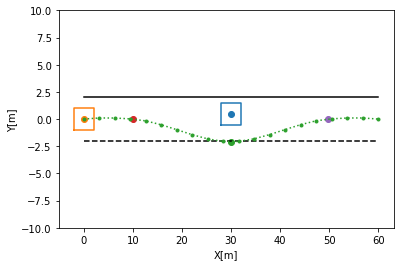

In [18]:
points = [
    [ego_vehicle.pos[0], parked_vehicle.pos[0] - pre, parked_vehicle.pos[0] + dx, parked_vehicle.pos[0] + back, line_center[0][1]], 
    [ego_vehicle.pos[1], ego_vehicle.pos[1], parked_vehicle.pos[1] + dy, ego_vehicle.pos[1], line_center[1][1]]
]

if 0:
    path_coef = np.polyfit(points[0], points[1], 6)
    path_x= np.linspace(ego_vehicle.pos[0], line_left[0][1], 20)
    path_y = np.poly1d(path_coef)(path_x)
else:
    path_x, path_y = spline2(points[0], points[1], 20)
    
eval_val = 0 
# (１)死角
w_dead_area = 1
eval_val += w_dead_area * calculation_dead_area(path_x, path_y, pre)
# (２)はみ出し
w_out_of_road = 100
eval_val += w_out_of_road * calculation_out_of_road(path_x, path_y)
# (３)衝突
w_collision = 1
eval_val += w_collision * calculation_collision(path_x, path_y)
# (４)道路中央を走行
w_center_of_road = 1
eval_val += w_center_of_road * calculation_center_of_road(path_x, path_y)
# (５)ジャーク（yの二回微分）
w_lat_jark = 1
eval_val += w_lat_jark * calculation_lat_jark(path_x, path_y)    
# (６)ハンドル角速度（曲率変化量） 
w_steer_vel = 1
eval_val += w_steer_vel * calculation_steer_vel(path_x, path_y)

print(eval_val)

plt.scatter(parked_vehicle.pos[0], parked_vehicle.pos[1])
vehicle_plot(parked_vehicle.pos, parked_vehicle.size, parked_vehicle.ori)
plt.scatter(ego_vehicle.pos[0], ego_vehicle.pos[1])
vehicle_plot(ego_vehicle.pos, ego_vehicle.size, ego_vehicle.ori)

plt.plot(line_left[0], line_left[1], 'k')
plt.plot(line_right[0], line_right[1], '--k')

plt.scatter(points[0][2], points[1][2])
plt.scatter(points[0][1], points[1][1])
plt.scatter(points[0][3], points[1][3])
plt.plot(path_x, path_y,':.')

plt.ylim([-10,10])
plt.xlabel('X[m]')
plt.ylabel('Y[m]')

In [19]:
calculation_dead_area(path_x, path_y,pre)

6482.475184308074

In [20]:
calculation_collision(path_x, path_y)

0.11023713934750698

In [21]:
calculation_center_of_road(path_x, path_y)

55.67781702807803

In [22]:
calculation_out_of_road(path_x, path_y)

6002

In [23]:
calculation_lat_jark(path_x, path_y)

2.0508675028391252

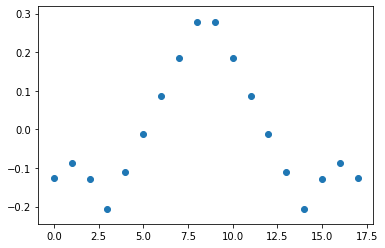

In [34]:
plt.scatter(range(len(np.diff(path_y, n=2))),np.diff(path_y, n=2))

In [35]:
calculation_steer_vel(path_x, path_y)

0.15245694946408567

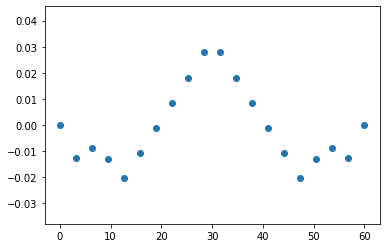

In [36]:
cv = CalcCurvature(path_x, path_y)
plt.scatter(path_x, cv)

In [37]:
dx, dy, pre, back = 0, -3, 20, 20

605794.9907681317


Text(0, 0.5, 'Y[m]')

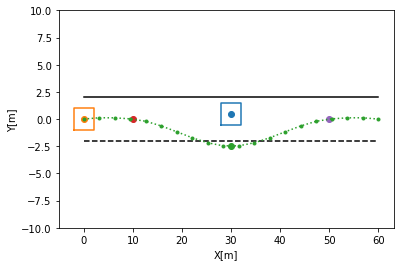

In [26]:
points = [
    [ego_vehicle.pos[0], parked_vehicle.pos[0] - pre, parked_vehicle.pos[0] + dx, parked_vehicle.pos[0] + back, line_center[0][1]], 
    [ego_vehicle.pos[1], ego_vehicle.pos[1], parked_vehicle.pos[1] + dy, ego_vehicle.pos[1], line_center[1][1]]
]

if 0:
    path_coef = np.polyfit(points[0], points[1], 6)
    path_x= np.linspace(ego_vehicle.pos[0], line_left[0][1], 20)
    path_y = np.poly1d(path_coef)(path_x)
else:
    path_x, path_y = spline2(points[0], points[1], 20)

eval_val = 0 
# (１)死角
w_dead_area = 1
eval_val += w_dead_area * calculation_dead_area(path_x, path_y, pre)
# (２)はみ出し
w_out_of_road = 100
eval_val += w_out_of_road * calculation_out_of_road(path_x, path_y)
# (３)衝突
w_collision = 1
eval_val += w_collision * calculation_collision(path_x, path_y)
# (４)道路中央を走行
w_center_of_road = 1
eval_val += w_center_of_road * calculation_center_of_road(path_x, path_y)
# (５)ジャーク（yの二回微分）
w_lat_jark = 1
eval_val += w_lat_jark * calculation_lat_jark(path_x, path_y)    
# (６)ハンドル角速度（曲率変化量） 
w_steer_vel = 1
eval_val += w_steer_vel * calculation_steer_vel(path_x, path_y)

print(eval_val)
    
plt.scatter(parked_vehicle.pos[0], parked_vehicle.pos[1])
vehicle_plot(parked_vehicle.pos, parked_vehicle.size, parked_vehicle.ori)
plt.scatter(ego_vehicle.pos[0], ego_vehicle.pos[1])
vehicle_plot(ego_vehicle.pos, ego_vehicle.size, ego_vehicle.ori)

plt.plot(line_left[0], line_left[1], 'k')
plt.plot(line_right[0], line_right[1], '--k')

plt.scatter(points[0][2], points[1][2])
plt.scatter(points[0][1], points[1][1])
plt.scatter(points[0][3], points[1][3])
plt.plot(path_x, path_y,':.')

plt.ylim([-10,10])
plt.xlabel('X[m]')
plt.ylabel('Y[m]')

In [27]:
calculation_dead_area(path_x, path_y,pre)

5318.870441559935

In [28]:
calculation_collision(path_x, path_y)

0.07903246735234593

In [29]:
calculation_center_of_road(path_x, path_y)

73.44606124008014

In [30]:
calculation_out_of_road(path_x, path_y)

6004

In [31]:
calculation_lat_jark(path_x, path_y)

2.442775914856395

In [32]:
calculation_steer_vel(path_x, path_y)

0.15245694946408567